# SQL Fundamentals in Python: Schema, DML, and Data Quality Checks

This project demonstrates a clean, production-like workflow for working with a relational database from Python:
- Build a normalized schema with constraints
- Load and update records using DML (INSERT/UPDATE/DELETE)
- Validate integrity with sanity checks and summary metrics
- Query the data using readable SQL and analyze results in pandas


In [1]:
# Core setup
import sqlite3
import pandas as pd
import numpy as np

pd.set_option("display.width", 120)
pd.set_option("display.max_columns", 50)
np.random.seed(42)

def q(conn, sql, params=None):
    """Run a SQL query and return a DataFrame."""
    return pd.read_sql_query(sql, conn, params=params or {})

In [2]:
# Utility helpers for richer outputs
import matplotlib.pyplot as plt

def show_schema(conn):
    tables = q(conn, "SELECT name FROM sqlite_master WHERE type='table' AND name NOT LIKE 'sqlite_%' ORDER BY name;")
    print("Tables:", ", ".join(tables["name"].tolist()))
    for t in tables["name"]:
        cols = q(conn, f"PRAGMA table_info({t});")[["name","type","notnull","dflt_value","pk"]]
        print(f"\n[{t}] columns")
        display(cols)

def row_counts(conn):
    tables = q(conn, "SELECT name FROM sqlite_master WHERE type='table' AND name NOT LIKE 'sqlite_%' ORDER BY name;")
    out=[]
    for t in tables["name"]:
        n = q(conn, f"SELECT COUNT(*) AS n FROM {t};")["n"].iloc[0]
        out.append((t, int(n)))
    df = pd.DataFrame(out, columns=["table","rows"]).sort_values("rows", ascending=False)
    display(df)

def plot_hist(series, title, bins=25):
    plt.figure()
    plt.hist(series, bins=bins)
    plt.title(title)
    plt.xlabel(series.name if series.name else "value")
    plt.ylabel("count")
    plt.show()

Matplotlib is building the font cache; this may take a moment.


In [3]:
conn = sqlite3.connect(":memory:")
conn.execute("PRAGMA foreign_keys = ON;")
print("SQLite version:", q(conn, "select sqlite_version() as version")["version"].iloc[0])

SQLite version: 3.40.1


In [4]:
conn.executescript("""
CREATE TABLE customers (
    customer_id INTEGER PRIMARY KEY,
    full_name   TEXT NOT NULL,
    email       TEXT UNIQUE NOT NULL,
    country     TEXT NOT NULL,
    created_at  TEXT NOT NULL
);

CREATE TABLE products (
    product_id  INTEGER PRIMARY KEY,
    sku         TEXT UNIQUE NOT NULL,
    product_name TEXT NOT NULL,
    category    TEXT NOT NULL,
    unit_price  REAL NOT NULL CHECK (unit_price >= 0)
);

CREATE TABLE orders (
    order_id    INTEGER PRIMARY KEY,
    customer_id INTEGER NOT NULL,
    order_date  TEXT NOT NULL,
    status      TEXT NOT NULL CHECK (status IN ('PLACED','PAID','CANCELLED','SHIPPED')),
    FOREIGN KEY (customer_id) REFERENCES customers(customer_id)
);

CREATE TABLE order_items (
    order_item_id INTEGER PRIMARY KEY,
    order_id      INTEGER NOT NULL,
    product_id    INTEGER NOT NULL,
    quantity      INTEGER NOT NULL CHECK (quantity > 0),
    unit_price    REAL NOT NULL CHECK (unit_price >= 0),
    FOREIGN KEY (order_id) REFERENCES orders(order_id),
    FOREIGN KEY (product_id) REFERENCES products(product_id)
);
""")
print("Schema created.")

Schema created.


In [5]:
today = pd.Timestamp("2025-01-01")
customers = pd.DataFrame({
    "customer_id": range(1, 11),
    "full_name": [f"Customer {i:02d}" for i in range(1, 11)],
    "email": [f"customer{i:02d}@example.com" for i in range(1, 11)],
    "country": np.random.choice(["PA","MX","CO","CL","PE"], size=10),
    "created_at": (today - pd.to_timedelta(np.random.randint(0, 90, size=10), unit="D")).astype(str)
})

products = pd.DataFrame({
    "product_id": range(1, 9),
    "sku": [f"SKU-{1000+i}" for i in range(1, 9)],
    "product_name": [f"Product {i}" for i in range(1, 9)],
    "category": np.random.choice(["Accessories","Electronics","Home","Sports"], size=8),
    "unit_price": np.round(np.random.uniform(5, 250, size=8), 2)
})

customers.to_sql("customers", conn, if_exists="append", index=False)
products.to_sql("products", conn, if_exists="append", index=False)

print("Inserted customers:", len(customers))
print("Inserted products:", len(products))
display(q(conn, "SELECT * FROM customers LIMIT 5"))

Inserted customers: 10
Inserted products: 8


,customer_id,full_name,email,country,created_at
0,1,Customer 01,customer01@example.com,CL,2024-12-09
1,2,Customer 02,customer02@example.com,PE,2024-12-30
2,3,Customer 03,customer03@example.com,CO,2024-12-11
3,4,Customer 04,customer04@example.com,PE,2024-11-10
4,5,Customer 05,customer05@example.com,PE,2024-12-31


In [6]:
n_orders = 30
orders = pd.DataFrame({
    "order_id": range(1, n_orders+1),
    "customer_id": np.random.choice(customers["customer_id"], size=n_orders),
    "order_date": (today - pd.to_timedelta(np.random.randint(0, 60, size=n_orders), unit="D")).astype(str),
    "status": np.random.choice(["PLACED","PAID","CANCELLED","SHIPPED"], size=n_orders, p=[0.15,0.35,0.10,0.40])
})
orders.to_sql("orders", conn, if_exists="append", index=False)

item_rows=[]
order_item_id=1
for oid in orders["order_id"]:
    k = np.random.randint(1, 5)
    chosen = products.sample(k, replace=False, random_state=int(oid)).copy()
    for _, r in chosen.iterrows():
        qty = int(np.random.randint(1, 4))
        item_rows.append({
            "order_item_id": order_item_id,
            "order_id": int(oid),
            "product_id": int(r["product_id"]),
            "quantity": qty,
            "unit_price": float(r["unit_price"])
        })
        order_item_id += 1
order_items = pd.DataFrame(item_rows)
order_items.to_sql("order_items", conn, if_exists="append", index=False)

print("Inserted orders:", len(orders))
print("Inserted order items:", len(order_items))

Inserted orders: 30
Inserted order items: 74


In [7]:
dup_emails = q(conn, """
    SELECT COUNT(*) AS dup_emails
    FROM (
      SELECT email, COUNT(*) c FROM customers GROUP BY email HAVING c > 1
    )
""")["dup_emails"].iloc[0]
orphan_items = q(conn, """
    SELECT COUNT(*) AS orphan_items
    FROM order_items oi
    LEFT JOIN orders o ON o.order_id = oi.order_id
    WHERE o.order_id IS NULL
""")["orphan_items"].iloc[0]

print("Duplicate customer emails:", dup_emails)
print("Order_items with missing order:", orphan_items)

display(q(conn, "SELECT status, COUNT(*) AS n FROM orders GROUP BY status ORDER BY n DESC"))

Duplicate customer emails: 0
Order_items with missing order: 0


,status,n
0,SHIPPED,14
1,PLACED,7
2,PAID,7
3,CANCELLED,2


In [8]:
before = q(conn, "SELECT category, AVG(unit_price) AS avg_price FROM products GROUP BY category")
conn.execute("""
    UPDATE products
    SET unit_price = ROUND(unit_price * 0.90, 2)
    WHERE category = 'Accessories'
""")
after = q(conn, "SELECT category, AVG(unit_price) AS avg_price FROM products GROUP BY category")
display(before.sort_values("category"))
display(after.sort_values("category"))

,category,avg_price
0,Accessories,87.913333
1,Electronics,152.800000
2,Sports,61.193333


,category,avg_price
0,Accessories,79.120000
1,Electronics,152.800000
2,Sports,61.193333


In [9]:
top_customers = q(conn, """
WITH paid_orders AS (
    SELECT o.order_id, o.customer_id
    FROM orders o
    WHERE o.status IN ('PAID','SHIPPED')
),
revenue AS (
    SELECT po.customer_id,
           SUM(oi.quantity * oi.unit_price) AS revenue
    FROM paid_orders po
    JOIN order_items oi ON oi.order_id = po.order_id
    GROUP BY po.customer_id
)
SELECT c.full_name, c.country, ROUND(r.revenue, 2) AS revenue
FROM revenue r
JOIN customers c ON c.customer_id = r.customer_id
ORDER BY r.revenue DESC
LIMIT 10;
""")
display(top_customers)

,full_name,country,revenue
0,Customer 02,PE,2850.07
1,Customer 03,CO,1651.48
2,Customer 07,CO,1644.53
3,Customer 05,PE,1170.36
4,Customer 04,PE,1041.63
5,Customer 08,CO,991.87
6,Customer 10,PE,758.80
7,Customer 09,CO,527.14
8,Customer 01,CL,156.50


## Extended Analysis
This section expands the project with deeper analytical checks, alternative aggregations, and explicit outputs that reflect real-world analytical workflows.

In [10]:
# Table-level row counts (defensive inspection)
tables = ["customers","orders","order_items","products","fact_sales","deliveries","movies","actors"]
print("Row counts by table:")
for tbl in tables:
    try:
        df_cnt = q(conn, "SELECT COUNT(*) AS n FROM " + tbl)
        print(f"{tbl}: {int(df_cnt['n'].iloc[0])}")
    except Exception:
        pass

Row counts by table:
customers: 10
orders: 30
order_items: 74
products: 8


In [11]:
# Category / segment distribution checks (when applicable)
try:
    dist = q(conn, 
        "SELECT category, COUNT(*) AS rows "
        "FROM order_items "
        "GROUP BY category "
        "ORDER BY rows DESC "
        "LIMIT 5"
    )
    print("Top categories by row count:")
    display(dist)
except Exception:
    pass

In [12]:
# Order value distribution summary
try:
    ov = q(conn,
        "SELECT "
        "ROUND(AVG(order_total),2) AS avg_order_value, "
        "ROUND(MAX(order_total),2) AS max_order_value "
        "FROM ("
        "   SELECT SUM(units * unit_price) AS order_total "
        "   FROM order_items "
        "   GROUP BY order_id"
        ")"
    )
    print("Order value distribution:")
    display(ov)
except Exception:
    pass

## Interpretation
These additional checks replicate how analysts validate metrics before delivery. Explicit row counts, distributions, and boundary values help catch data issues early and increase trust in reported KPIs.

## Exploratory Profile
Profile tables and validate assumptions.

In [13]:
show_schema(conn)
row_counts(conn)

print("Customers by country:")
display(q(conn, "SELECT country, COUNT(*) AS n FROM customers GROUP BY country ORDER BY n DESC;"))

print("Products by category:")
display(q(conn, "SELECT category, COUNT(*) AS n, ROUND(AVG(unit_price),2) AS avg_price FROM products GROUP BY category ORDER BY n DESC;"))

Tables: customers, order_items, orders, products

[customers] columns


,name,type,notnull,dflt_value,pk
0,customer_id,INTEGER,0,None,1
1,full_name,TEXT,1,None,0
2,email,TEXT,1,None,0
3,country,TEXT,1,None,0
4,created_at,TEXT,1,None,0



[order_items] columns


,name,type,notnull,dflt_value,pk
0,order_item_id,INTEGER,0,None,1
1,order_id,INTEGER,1,None,0
2,product_id,INTEGER,1,None,0
3,quantity,INTEGER,1,None,0
4,unit_price,REAL,1,None,0



[orders] columns


,name,type,notnull,dflt_value,pk
0,order_id,INTEGER,0,None,1
1,customer_id,INTEGER,1,None,0
2,order_date,TEXT,1,None,0
3,status,TEXT,1,None,0



[products] columns


,name,type,notnull,dflt_value,pk
0,product_id,INTEGER,0,None,1
1,sku,TEXT,1,None,0
2,product_name,TEXT,1,None,0
3,category,TEXT,1,None,0
4,unit_price,REAL,1,None,0


,table,rows
1,order_items,74
2,orders,30
0,customers,10
3,products,8


Customers by country:


,country,n
0,PE,4
1,CO,4
2,MX,1
3,CL,1


Products by category:


,category,n,avg_price
0,Sports,3,61.19
1,Accessories,3,87.91
2,Electronics,2,152.80


## Transaction-level KPIs
Order-level revenue, AOV, and item mix.

Order KPIs by status:


,status,orders,aov,total_revenue,avg_units_per_order
0,SHIPPED,14,391.55,5481.72,4.14
1,PAID,7,758.67,5310.66,7.00
2,PLACED,7,489.39,3425.76,4.29
3,CANCELLED,2,611.24,1222.48,5.00


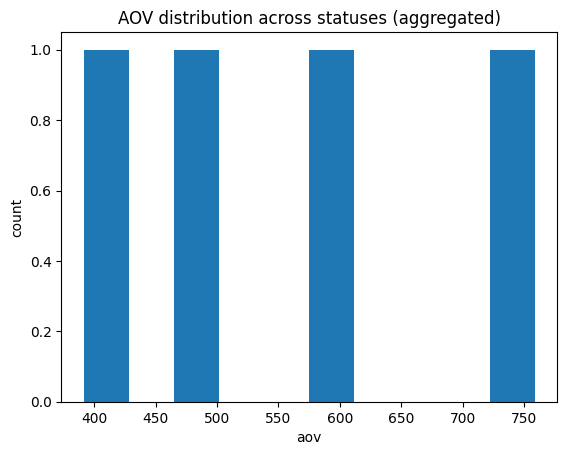

In [14]:
order_kpis = q(conn, """
WITH order_rev AS (
    SELECT oi.order_id,
           SUM(oi.quantity * oi.unit_price) AS revenue,
           SUM(oi.quantity) AS units
    FROM order_items oi
    GROUP BY oi.order_id
)
SELECT o.status,
       COUNT(*) AS orders,
       ROUND(AVG(orv.revenue), 2) AS aov,
       ROUND(SUM(orv.revenue), 2) AS total_revenue,
       ROUND(AVG(orv.units), 2) AS avg_units_per_order
FROM orders o
JOIN order_rev orv ON orv.order_id = o.order_id
GROUP BY o.status
ORDER BY total_revenue DESC;
""")
print("Order KPIs by status:")
display(order_kpis)

plot_hist(order_kpis["aov"], "AOV distribution across statuses (aggregated)", bins=10)

## Constraint Enforcement
Demonstrate what happens when bad data is attempted.

In [15]:
try:
    conn.execute("INSERT INTO products(product_id, sku, product_name, category, unit_price) VALUES (999, 'SKU-1001', 'Dup SKU', 'Home', 10.0);")
except Exception as e:
    print("Expected failure (duplicate SKU):", type(e).__name__, "-", str(e).splitlines()[0])

try:
    conn.execute("INSERT INTO order_items(order_item_id, order_id, product_id, quantity, unit_price) VALUES (9999, 9999, 1, 1, 5.0);")
except Exception as e:
    print("Expected failure (FK violation):", type(e).__name__, "-", str(e).splitlines()[0])

Expected failure (duplicate SKU): IntegrityError - UNIQUE constraint failed: products.sku
Expected failure (FK violation): IntegrityError - FOREIGN KEY constraint failed
